<CENTER>
    <a href="http://opendata.atlas.cern" class="icons"><img src="../Assets/ATLASOD.gif" style="width:50%"></a>
</CENTER>

<CENTER><h1>Example of the reconstruction of the invariant Mass of the Z boson in C++</h1></CENTER>

<CENTER>
<img src="../Assets/Z_ElectronPositron.png" style="width:30%">
</CENTER>

<b>Introduction</b> Let's take a current ATLAS Open Data sample and create a histogram:

In [1]:
//%jsroot on

We need to include some standard C++ and ROOT libraries

In [2]:
#include <iostream>
#include <string>
#include <stdio.h>
#include <time.h>

Because we would like to use more than one ROOT input file, the best option is to use a TChain object. This allows to "chain" several samples into a single structure that we can later loop over

In [3]:
TChain *MonteCarlo = new TChain("mini");

We're using two MonteCarlodirectly from the ATLAS Open Data. In this case, two Z->ll simulated samples:

In [4]:
MonteCarlo->Add("http://opendata.atlas.cern/release/samples/MC/mc_147770.Zee.root ");
MonteCarlo->Add("http://opendata.atlas.cern/release/samples/MC/mc_147771.Zmumu.root");

We're extracting generic variables, like the RunNumber. This is a vwariable that heps to identify the sample inside the analysis code

In [5]:
Int_t MonteCarlo_runNumber = -1;   //Run identifier

Now we're going to extract the leptons variables

In [6]:
Int_t  MonteCarlo_lep_n = -1,      //number of preselected leptons
       MonteCarlo_lep_type[5];     //number signifying the lepton type (e, mu, tau) of the lepton

Float_t MonteCarlo_lep_pt[5],      //transverse momentum of the lepton
        MonteCarlo_lep_charge[5],  //charge of the lep
        MonteCarlo_lep_eta[5],     //pseudorapidity of the lepton
        MonteCarlo_lep_phi[5],     //azimuthal angle of the lepton
        MonteCarlo_lep_E[5];       //energy of the lepton

Here we're filling the variables defined above with the content of those inside the input ntuples

In [7]:
//MonteCarlo
MonteCarlo->SetBranchAddress("channelNumber", &MonteCarlo_runNumber);

MonteCarlo->SetBranchAddress("lep_pt",        &MonteCarlo_lep_pt);
MonteCarlo->SetBranchAddress("lep_charge",    &MonteCarlo_lep_charge);
MonteCarlo->SetBranchAddress("lep_n",         &MonteCarlo_lep_n);
MonteCarlo->SetBranchAddress("lep_type",      &MonteCarlo_lep_type);
MonteCarlo->SetBranchAddress("lep_eta",       &MonteCarlo_lep_eta);
MonteCarlo->SetBranchAddress("lep_phi",       &MonteCarlo_lep_phi);
MonteCarlo->SetBranchAddress("lep_E",         &MonteCarlo_lep_E);

We're creating two (2) histograms for this example. The plan in to fill them with events coming from different input MC samples

In [8]:
//Invariant mass histograms definition
TH1F *h_M_Zee   = new TH1F("h_M_Zee"  ,  "Invariant Mass of the Z (Zee) ; M_Zee[GeV] ; # de eventos" ,20,0,150);
TH1F *h_M_Zmumu = new TH1F("h_M_Zmumu","Invariant Mass of the Z (Zmumu) ; M_Zmumu[GeV] ; # de eventos" ,20,0,150);

We are selecting below a simple look for them

In [9]:
h_M_Zee->SetMarkerSize(2.0);
h_M_Zee->SetLineColor(kBlue);
h_M_Zee->SetFillColor(kBlue-10);

h_M_Zmumu->SetMarkerSize(2.0);
h_M_Zmumu->SetLineColor(kGreen);
h_M_Zmumu->SetFillColor(kGreen-10);

The Z boson analysis implemented here considers Z boson decays into a electron-positron or muon-antimuon pair. The event selection criteria are:

In [10]:
int nentriesMC, nbytesMC, i;
nentriesMC = (Int_t)MonteCarlo->GetEntries();

std::cout << " Total number of entries to analyze: " << nentriesMC << std::endl;

for (i=0;i< nentriesMC; i++)
{
    nbytesMC =  MonteCarlo->GetEntry(i);
    
    //Cut #1: We just want events with at least two leptons
    if(MonteCarlo_lep_n>1)
    {   
        // TLorentzVector definitions 
        TLorentzVector Lepton_1  = TLorentzVector();
        TLorentzVector Lepton_2  = TLorentzVector();
        
        Lepton_1.SetPtEtaPhiE(MonteCarlo_lep_pt[0], MonteCarlo_lep_eta[0], MonteCarlo_lep_phi[0],MonteCarlo_lep_E[0]);
        Lepton_2.SetPtEtaPhiE(MonteCarlo_lep_pt[1], MonteCarlo_lep_eta[1], MonteCarlo_lep_phi[1],MonteCarlo_lep_E[1]);
                
        //Cut #2: Exactly two good leptons with pT > 25GeV
        if(MonteCarlo_lep_n ==2 || MonteCarlo_lep_pt[2] <25000.)
        {
          //Cut #3: The two selected leptons must have opposite charge
          int OS = MonteCarlo_lep_charge[0]*MonteCarlo_lep_charge[1];
          if(OS == -1)
          {  
               //Cut 4: The two selected leptons have the same flauvour
               if(MonteCarlo_lep_type[0] == MonteCarlo_lep_type[1])
               {
                   //Calculation of the Invariant Mass using TLorentz vectors
                   TLorentzVector Lepton_12 = Lepton_1 + Lepton_2;
                   
                   float mass_inv_GeV = Lepton_12.M()/1000.;

                   /*Cut #4: The absolute value of the difference between the two leptons and the known Z boson mass 
                   (mz) must be less than 20 GeV (|mll - mz| < 20 GeV) with mz= 91.18GeV */
                    if(TMath::Abs(mass_inv_GeV  - 90.18) < 20)
                    {
                        /*The runNumber value helps to separate the samples*/
                        if(MonteCarlo_runNumber ==147770) // where 147770 == Zee
                        {
                            h_M_Zee->Fill(mass_inv_GeV); // invariant mass of two electrons
                        }
                        else if(MonteCarlo_runNumber ==147771) // where 147771 == Zmumu
                        {
                            h_M_Zmumu->Fill(mass_inv_GeV); // invariant mass of two muons 
                        }
                    }
                }
            }
        }
    }
}

 Total number of entries to analyze: 15000000


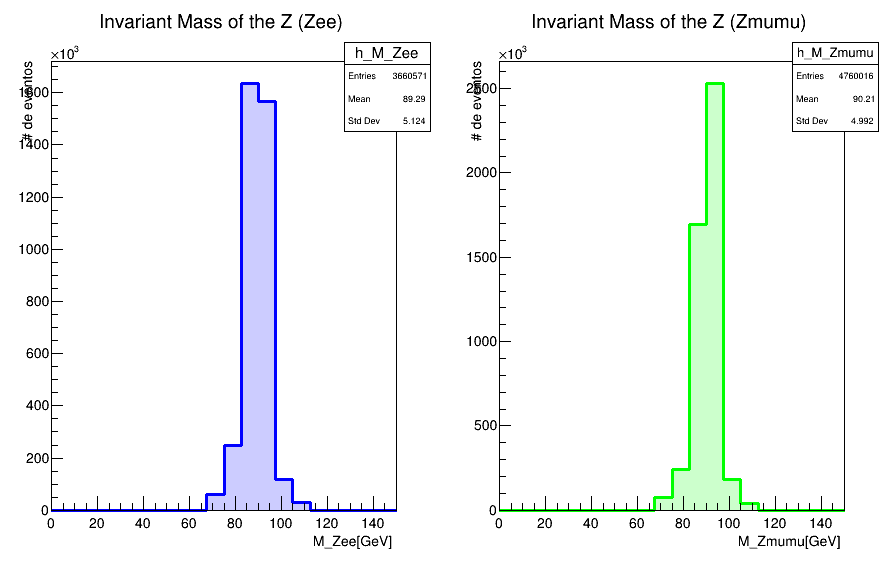

In [11]:
TCanvas *cz = new TCanvas("cz","cz",10,10,900,600);
    TText tz; tz.SetTextFont(42); tz.SetTextAlign(21);
    cz->Divide(2,1);
    cz->cd(1); h_M_Zee->Draw();
    cz->cd(2); h_M_Zmumu->Draw();

cz->Draw();

<p>You can insert <b>HTML code</b> in other to get better documentation of the notebook...</p>